### 1. 开始

- 将numpy和matplotlib通过pylab导入，并导入caffe，设置matplotlib为行内模式

In [23]:
from pylab import *
%matplotlib inline


In [24]:
caffe_root = '...'  # 编译完的caffe的根目录,请根据自己的情况填写
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

- 没有任何报错，我们继续，下面的代码将从caffe的根目录运行，分别下载所需的数据和准备数据

In [25]:
import os
os.chdir(caffe_root)
# Download data
!data/mnist/get_mnist.sh
# Prepare data
!examples/mnist/create_mnist.sh
# back to examples
os.chdir('examples')

Downloading...
Creating lmdb...
I1015 20:06:56.133891 2598978496 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_train_lmdb
I1015 20:06:56.135215 2598978496 convert_mnist_data.cpp:88] A total of 60000 items.
I1015 20:06:56.135231 2598978496 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I1015 20:06:56.430887 2598978496 convert_mnist_data.cpp:108] Processed 60000 files.
I1015 20:06:56.469127 2598978496 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_test_lmdb
I1015 20:06:56.470183 2598978496 convert_mnist_data.cpp:88] A total of 10000 items.
I1015 20:06:56.470198 2598978496 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I1015 20:06:56.523572 2598978496 convert_mnist_data.cpp:108] Processed 10000 files.
Done.


- 一切正常，继续，若报错，请根据报错信息查阅caffe编译安装教程

### 2. 创建网络
现在我们要创建一个LeNet的变体，LeNet具体详见第一章
我们将使用两个外部的文件：
- net prototxt,定义了模型的架构并指定了训练数据（train/test）
- solver prototxt,定义了所需学习的参数

开始创建网络了，我们将用简明扼要的Python代码书写创建代码，这些代码将生成标准的protobuf模型格式

这个网络将从预生成的LMDBs中读取数据，但是使用MemoryDataLayer直接从ndarrays也是可以的

In [26]:
from caffe import layers as L, params as P

def lenet(lmdb, batch_size):
    # 我们的LeNet很简单，就是一些线性层和非线性层
    n = caffe.NetSpec()
    
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()
    
# 将创建好的网络配置以Google protobuf格式写入相应的文本文件中，可读性差点，但是对于机器来说更精确，
# 当然，你是可以直接自己编辑这些文本文件的
with open('mnist/lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_train_lmdb', 64)))
    
with open('mnist/lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_test_lmdb', 100)))

In [27]:
# 查看这些文本文件是否正确生成
!cat mnist/lenet_auto_train.prototxt
!cat mnist/lenet_auto_solver.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156862745
  }
  data_param {
    source: "mnist/mnist_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 20
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {
    num_output: 50
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "fc1"
  type: "InnerProduct"
  bottom: "pool2"
  top: "fc1"
  inner_product_param {
    num_out

### 3.载入并检查solver
* 我们将使用随机梯度下降作为优化方法来生成我们的solver

In [28]:
solver = None  
solver = caffe.SGDSolver('mnist/lenet_auto_solver.prototxt')

* 检查下我们定义的这些layer中的blob的维数是否正确，以及我们的参数

In [29]:
# 每个输出都应该是 (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (64, 1, 28, 28)),
 ('label', (64,)),
 ('conv1', (64, 20, 24, 24)),
 ('pool1', (64, 20, 12, 12)),
 ('conv2', (64, 50, 8, 8)),
 ('pool2', (64, 50, 4, 4)),
 ('fc1', (64, 500)),
 ('score', (64, 10)),
 ('loss', ())]

In [30]:
# 打印一下权重的大小，忽略了偏置
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (20, 1, 5, 5)),
 ('conv2', (50, 20, 5, 5)),
 ('fc1', (500, 800)),
 ('score', (10, 500))]

In [31]:
solver.net.forward()  # 训练我们的网络
solver.test_nets[0].forward()  # 再测试下我们训练出的网络

{'loss': array(2.412365674972534, dtype=float32)}

train labels: [ 5.  0.  4.  1.  9.  2.  1.  3.]


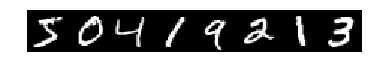

In [32]:
# 我们来显示一组训练数据并显示其类表号
imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'train labels:', solver.net.blobs['label'].data[:8]

test labels: [ 7.  2.  1.  0.  4.  1.  4.  9.]


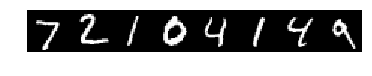

In [33]:
# 再看一组测试数据，可见正确率为100%
imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'test labels:', solver.test_nets[0].blobs['label'].data[:8]

### 4. 将Solver推进一步

训练网络和测试网络都正确载入了数据，并将样本正确标定类标号。

* 让我们使用minibatch将SGD（随机梯度下降）推进一步，然后看看发生了什么

In [34]:
solver.step(1)

我们是否将梯度下降传递到滤波器了呢？来看一下第一层的更新（第一卷积层的参数更新），这里展示了一个$4 \times 5$的滤波器阵列，每个滤波器的大小是$5 \times 5$。

(-0.5, 24.5, 19.5, -0.5)

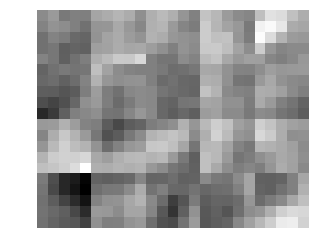

In [35]:
imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray'); axis('off')

### 5.下面我们来试着写一个自己的训练过程

注意，一些神奇的事情正在发生，让我们将网络运行一会儿时间，对一些在变化的事情保持注意。

注意到，这些训练过程如果是使用命令行，效果是一样的（`caffe`命令），特别的：

* 日志都会正常记录下来
* 将会在solver prototxt中标识的地方进行快照（在这里是每5000轮迭代）
* 测试同样会在标识的地方进行（在这里是500轮迭代）

在Python中，我们可以对循环进行控制，因此，在循环中我们还能计算一些其他的东西，如下所示，当然，我们能很多其他的事情。
* 自定义停止条件
* 在循环中更新网络以改变solving过程


In [36]:
%%time
niter = 200
test_interval = 25
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # 存储训练中的损失
    train_loss[it] = solver.net.blobs['loss'].data
    
    # 存储第一批训练数据的输出
    # (从conv1开始前向传播以避免多次载入数据）
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['score'].data[:8]
    # 每隔一段时间运行全部的测试
    # Caffe同样可以帮我们做这些，还能输出日志，但我们直接在这里展示如何直接在python中做这些，python创造美好生活
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...
CPU times: user 34.8 s, sys: 3.67 s, total: 38.5 s
Wall time: 31 s


* 画出训练损失和测试准确度

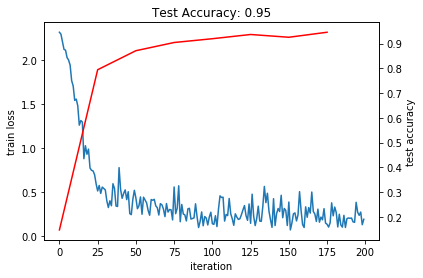

In [37]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))

损失好像下落地非常迅速，并且被覆盖了（我们期望的是随机的），但是与此同时，准确度却相应地上升了，万岁！

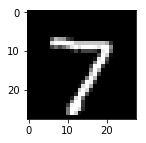

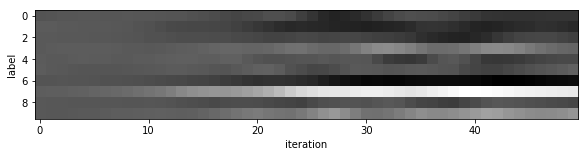

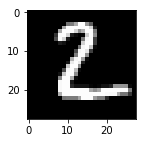

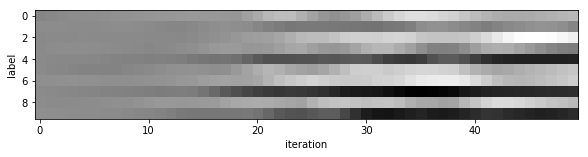

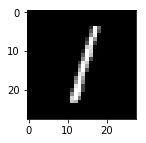

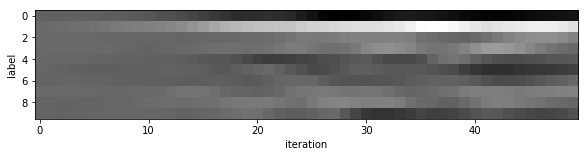

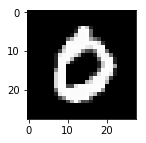

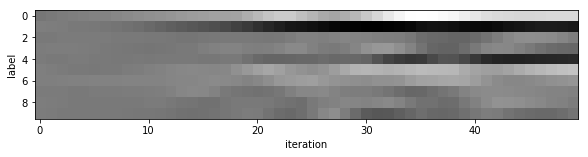

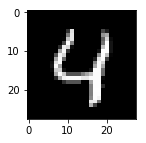

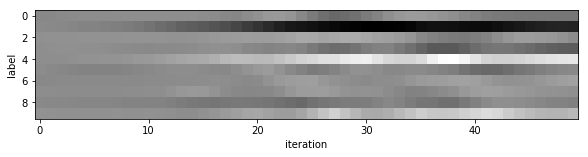

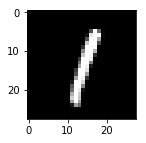

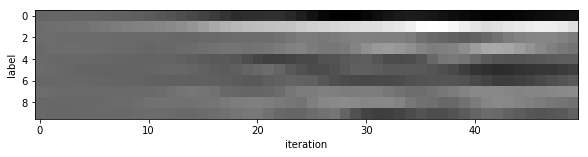

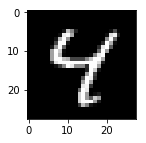

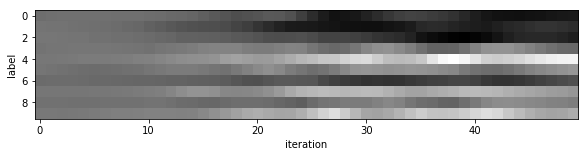

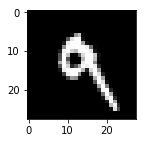

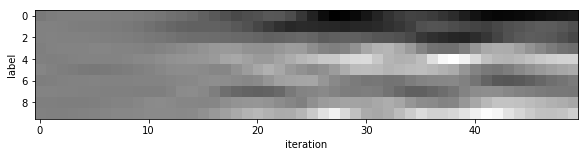

In [38]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(output[:50, i].T, interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')